# MNIST classification with Lenet

필요한 모든 라이브러리 import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

## MNIST dataset load

1. torchvision.datasets 모듈에서 MNIST 훈련 데이터셋을 불러와 정규화를 위해 평균, 표준편차 구하기
2. 
- 훈련 데이터셋의 transform 정의
- Random Rotation by degree 5
- padding 2를 먼저 붙이고 random crop
- 텐서화 (ToTensor)
- 평균, 표준편차로 정규화

- 테스트 데이터셋의 transform 정의
- 텐서화
- 평균, 표준편차로 정규화
3. torch.utils.data.random_split 메소드를 이용해 90/10 비율로 train/val 데이터셋 구성
4. valid data의 transformation을 test_transformation으로 재정의
5. 배치 사이즈를 64로 한 train/val/test dataloader 구성


torchvision.datasets 모듈에서 MNIST 훈련 데이터셋을 불러와 정규화를 위해 평균, 표준편차 구하기

In [2]:
train_data = datasets.MNIST(root='./data', train=True, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [8]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255
print(f'Mean {mean:.3f}, Std {std:.3f}')

Mean 0.131, Std 0.308


훈련 데이터셋의 transform 정의
- Random Rotation by degree 5
- padding 2를 먼저 붙이고 random crop
- 텐서화 (ToTensor)
- 평균, 표준편차로 정규화

테스트 데이터셋의 transform 정의
- 텐서화
- 평균, 표준편차로 정규화


In [14]:
train_transform = transforms.Compose([
                            transforms.RandomRotation(5, fill=0),
                            transforms.RandomCrop(size=28, padding=2),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[mean], std=[std])
                                    ])
test_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                    ])

정의한 transformation 기반으로 데이터셋 로드

In [15]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

torch.utils.data.random_split 메소드를 이용해 90/10 비율로 train/val 데이터셋 구성

In [16]:
ratio = 0.9
num_trains = int(len(train_data)*ratio)
num_vals = len(train_data) - num_trains

train_data, val_data = data.random_split(train_data, [num_trains, num_vals])
print(f'Length of Train Dataset: {len(train_data)}')

Length of Train Dataset: 54000


Validation 데이터셋의 transform 을 test_transform 으로 변환

In [18]:
val_data.dataset.transform = test_transform

train/val/test 데이터셋의 크기 출력

In [19]:
print(f'Length of Train Dataset: {len(train_data)}')
print(f'Length of Val Dataset: {len(val_data)}')
print(f'Length of Test Dataset: {len(test_data)}')

Length of Train Dataset: 54000
Length of Val Dataset: 6000
Length of Test Dataset: 10000


배치 사이즈를 64로 하여 dataloader 구성

In [20]:
batch_size = 64

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_iterator = data.DataLoader(val_data, batch_size=batch_size)
test_iterator = data.DataLoader(test_data, batch_size=batch_size)

Generator - Yield

In [22]:
X, y = next(iter(train_iterator))
print(X.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


## Define Model

### Convolution

The LeNet architectures, and almost every modern neural network computer vision architecture makes use of convolutional neural network (CNN) layers. 

So, what is a CNN layer? Each convolutional layer has a number of *filters*, also commonly referred to as *kernels*. A filter is a (usually) square matrix that slides across the pixels in an image from left-to-right, top-to-bottom. At each "step", the filter performs a [convolution](https://en.wikipedia.org/wiki/Convolution) operation on the image. The output of the convolutional layer is the result of these convolutions after the filter's final "step". 

**Note:** in machine learning frameworks there aren't actually "steps", the result for every filter location is calculated at the same time, in parallel. This is a lot faster than actually stepping through the image, but thinking about it in terms of steps makes everything easier to visualize.

Let's have a look at a single 2x2 filter passing over an image. We'll pretend the image is 10x10 pixels in this example.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/filter-mnist.png?raw=1)

The filter (red) slides over the pixels of the image, stepping one pixel at a time. The size of the steps is called the *stride*, and we use a stride of one in this implementation, which means the filter moves one pixel at a time horizontally and moves one pixel down once it reaches the end of a row. The result of the convolution operation (green) is a pixel in the filtered image. All of these convolutions produce a new, filtered image.

Notice how the image coming out of the CNN layer is smaller than the image coming into the CNN. This is because the 2x2 filter has only nine steps horizontally and vertically. If we wanted to keep the output image the same size as the input image we could add padding - usually black pixels - around our image. 

When we have no padding and a step size of one, the size of the output image is: 

$$\text{height}_{\text{out}} = \text{height}_{\text{in}} - \text{filter}_{\text{height}} + 1$$

$$\text{width}_{\text{out}} = \text{width}_{\text{in}} - \text{filter}_{\text{width}} + 1$$

How do we calculate the values of the output pixels using the filter? It's simply a multiply and add! Each of the input image pixels covered by a filter is multiplied by the filter's weight over that pixel. All of these products are then summed together to get the value of the pixel in the output image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-filter.png?raw=1)

The same weights are used by the filter over the whole image. The weights do not change depending on the filters location within the image. One nice thing about this is that that the filters (and the convolutional layers themselves) are *translation invariant*, that means it doesn't matter where a feature (curve, edge, line) appears in an image, the convolutional layer will find all occurences of it. 

The weights for the filters, much like the weights of the linear layers in multilayer perceptrons, are learned via gradient descent and backpropagation.

Why are convolutional neural networks structured in this way? Filters applied across an image in this way can be used to detect patterns such as horizontal and vertical lines within an image. These patterns can be thought of as features of the image, which our CNN extracts. These extracted features can then be combined in further layers of the neural network with other extracted features and together create higher level features, e.g. a certain position and orientation of two lines make a cross, which can indicate the centre of a handwritten 4.

CNNs are also inspired by classic computer vision techniques, like [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator). Let's try manually choosing weights of a 3x3 filter to make Sobel filters and apply them to some of the MNIST digits to see what type of things our CNN layers can learn.

The `plot_filter` function takes in a batch of images and a two-dimensional filter and plots the output of that filter applied to all of the images.

In [24]:
def plot_filter(images, filter):

    images = images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    
    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    fig = plt.figure(figsize = (20, 5))
    
    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap = 'bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title(f'Filtered')
        ax.axis('off');

We'll then get a batch of images to test our handwritten Sobel filters on. We get the images from the test set as they're easier to examine without the transforms applied to them.

In [25]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

The first filter is for detecting horizontal lines.

We can see on the filtered images that the highest values (the whitest pixels) of the filtered image are where there is a horizontal line that is black on top and white below, e.g. the top of the 7 digit. The lowest values (the blackest pixels) of the filtered image are where there is a horizontal line that goes from white to black, e.g. the bottoms of all of the digits.

In [27]:
import matplotlib.pyplot as plt

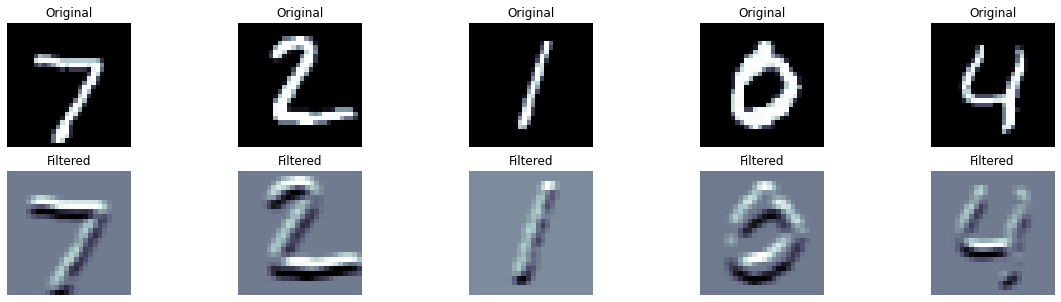

In [28]:
horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

By swapping the first and last rows of the above filter, we get a filter that detects horizontal lines from white on top to black underneath.

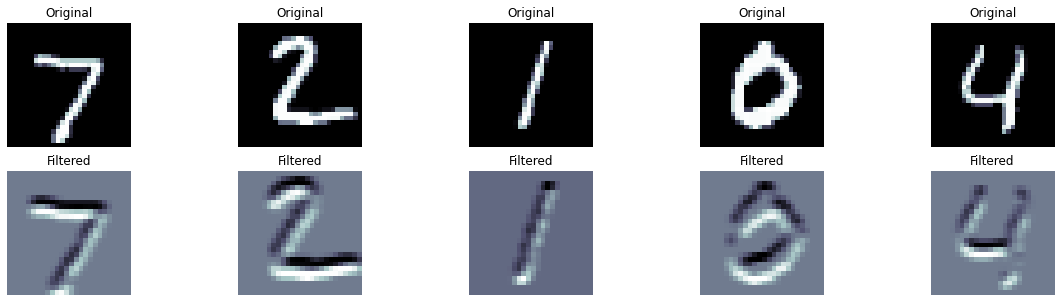

In [29]:
horizontal_filter = [[ 1,  2,  1],
                     [ 0,  0,  0],
                     [-1, -2, -1]]

plot_filter(images, horizontal_filter)

We can also design filters that detect vertical lines. 

Here's one that detects vertical lines that are black on the left and white on the right.

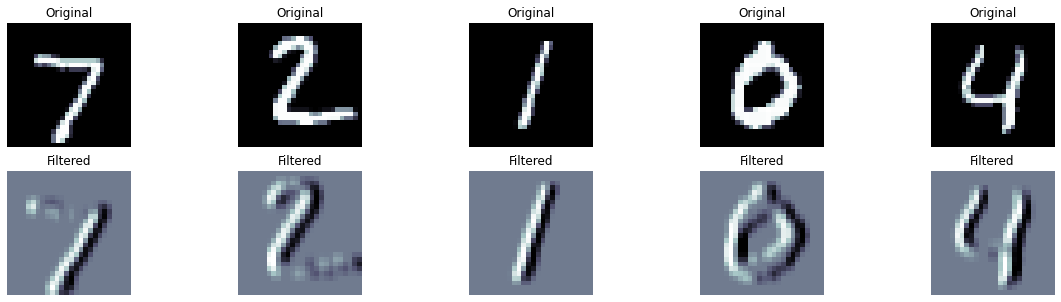

In [30]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

The great thing about convolutional layers is that each layer doesn't just have a single filter. It has as many filters as you want. Each filter has their own set of weights, so (in theory) is learning to extract different features. 

The image below shows what happens when we use a convolutional layer with five filters. The original image with a single color channel (as it's black and white) has five filters applied to it to get five filtered images. These images are then stacked together to get what we can think of as a single image with five channels.  

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-filter-mnist.png?raw=1)

What about when you now want to pass this five channel filtered image to another convolutional layer? Now, that convolutional layer won't just have a height and a width, but it will also have a depth equal to the number of channels in the input image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-channel-mnist.png?raw=1)

As you can see, the filter has a height, width and depth of 2x2x5. All of the 20 pixel values covered by this filter are multiplied by the filter's weight and then summed. The result of this will have as many channels as there are filters, and a subsequent convolutional layer will have to have filters with a depth equal to that number of channels.

Hopefully that's enough on convolutional layers, but if not then there are [plenty](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) of [other](https://cs231n.github.io/convolutional-networks/) resources [about](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) them [online](https://www.coursera.org/learn/convolutional-neural-networks).

Next, we'll talk about the subsampling layers. These are layers used to reduce the size/resolution of their input and are commonly applied to the output of convolutional layers. The most common two methods of subsampling are *max pooling* and *mean pooling* (also known as *average pooling*), and thus subsampling is often know as *pooling*.

Why do we want to reduce the resolution of the image? It speeds up our model, as convolution operations are expensive. If we subsample and half the size of our image before it passes into the next convolutional layer, that's a significant speed up.

Subsampling layers aren't too different to convolutional layers. They have a filter with a size and a stride. However, pooling layers do not have any parameters - weights and biases. They simply perform an operation on the image. Max pooling returns the maximum of the values covered by the filter and we can think of it as extracting the single most important feature under the filter. Mean/average pooling returns the mean/average of the values covered by the filter and we can think of it as equally weighting all features under the filter.

Let's look at a 2x2 pooling operation, with a stride of 2, over an image:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/subsample-mnist.png?raw=1)

Commonly, and by default in PyTorch, the stride for the height and the width is the height and the width of the filter and each pixel is only seen by the pooling layer once, thus:

$$\text{height}_{\text{out}} = \frac{\text{height}_\text{in}}{\text{filter}_{\text{height}}}$$

$$\text{width}_{\text{out}} = \frac{\text{width}_\text{in}}{\text{filter}_{\text{width}}}$$

For max pooling, the value of the output for each filter location is:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-pool.png?raw=1)

Let's create a function that allows us to see the outputs of a pooling layer on a batch of images.

In [31]:
def plot_subsample(images, pool_type, pool_size):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    
    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in  ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')
    
    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size = pool_size)

    fig = plt.figure(figsize = (20, 5))
    
    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title(f'Subsampled')
        ax.axis('off');

First, let's see max pooling with a filter size of 2. 

We can see that the image is heavily downsampled - reduced in size/resolution and in quality.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


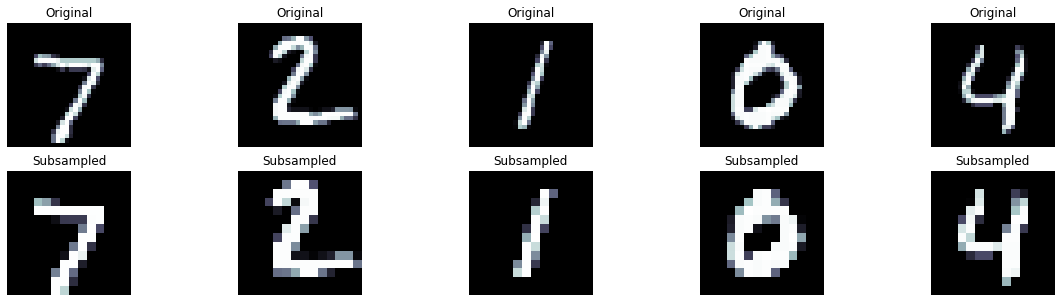

In [32]:
plot_subsample(images, 'max', 2)

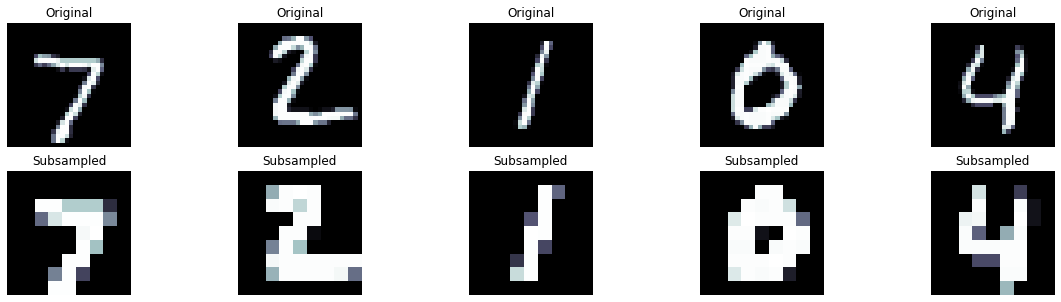

In [33]:
plot_subsample(images, 'max', 3)

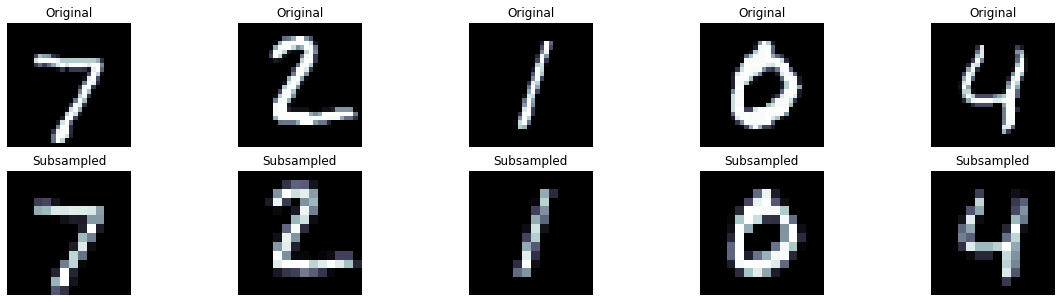

In [34]:
plot_subsample(images, 'avg', 2)

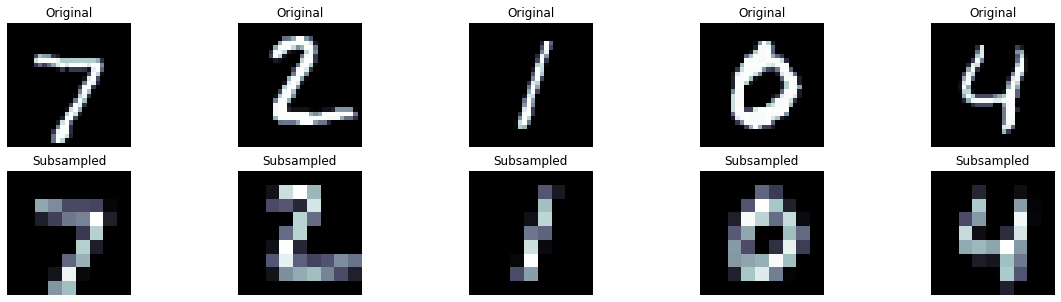

In [35]:
plot_subsample(images, 'avg', 3)

### Define Model with nn.Module

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)

The first layer in our model is convolutional layer with 6 filters (PyTorch calls them `out_channels`) and a kernel size of 5. This turns our `[1, 28, 28]` image into `[6, 24, 24]`. We then downsample our image with a max pooling layer that has a filter size of 2 to get a `[6, 12, 12]` image. This is then passed through an activation function, ReLU in this case, which is applied elementwise and does not change the of the image. 

Afterwards, we pass the image to the second convolutional layer with 16 filters that are 5x5x6, a height and width of 5 and a depth of 6 as our previous convolutional layer had 6 filters. This gives us an image size of `[16, 8, 8]` which we then max pool to half the heigth and width to `[16, 4, 4]` and then pass through another ReLU function.

We then flatten our `[16, 4, 4]` image to `[256]` and pass this through three linear layers. Each of the linear layers are followed by another ReLU, except for the last.

We return the results from the final linear layer as well as from the flattened result of the second convolutional layer, which we can plot in lower dimensions later.

Note that you should always apply your activation function **after** the pooling layer. You will get the exact same results if you apply the activation function before, however this means you will be applying your activation function to a larger number of inputs, increasing the computation required. Using the activation function after the image has been reduced in size means it will be applied to less inputs and thus use less computation.

- Subsampling: forward 메소드 안에서 F.maxpool_2d 사용
- ReLU: forward 메소드 안에서 F.relu 사용
- 나머지 convolution / fc 들은 __init__ 메소드 안에 구현

In [54]:
class Lenet(nn.Module):
    def __init__(self, in_channel=1, out_channel=10):
        super().__init__()

        ## 1st convolution
        ## kernel size 5, output channel 6
        self.conv1 = nn.Conv2d(in_channels=in_channel, 
                               out_channels=6,
                               kernel_size=5)

        ## 2nd convolution
        ## kernel size 5, output channel 16
        self.conv2 = nn.Conv2d(in_channels=6, 
                               out_channels=16,
                               kernel_size=5)
        
        self.flatten = nn.Flatten()

        ## 1st fc
        ## 16*4*4, 120
        self.fc1 = nn.Linear(in_features=16*4*4, out_features=120)

        ## 2nd fc
        ## 120, 84
        self.fc2 = nn.Linear(in_features=120, out_features=84)

        ## Last fc
        ## 84, 10
        self.fc3 = nn.Linear(in_features=84, out_features=out_channel)


    def forward(self, x):
        ## x: [batch size, 1, 28, 28]

        ## 1st conv
        x = self.conv1(x)
        print(f'Conv1: {x.shape}')

        ## Max-Pooling 
        x = F.max_pool2d(x, kernel_size=2)
        print(f'Max-Pool: {x.shape}')

        ## ReLU
        x = F.relu(x)

        ## 2nd conv
        x = self.conv2(x)
        print(f'Conv2: {x.shape}')

        ## Max-Pooling
        x = F.max_pool2d(x, kernel_size=2)
        print(f'Max-Pool: {x.shape}')

        ## ReLU
        x = F.relu(x)

        ## Flatten: [batch_size, 16, 4, 4] -> [batch_size, 256]
        ## 1st way
        x = x.view(x.shape[0], -1) # numpy reshape
        ## 2nd way
        #x = self.flatten(x)
        h = x
        print(f'Flatten: {x.shape}')

        ## 1st fc
        x = self.fc1(x)
        print(f'FC1: {x.shape}')

        ## ReLU
        x = F.relu(x)

        ## 2nd fc
        x = self.fc2(x)
        print(f'FC2: {x.shape}')

        ## ReLU
        x = F.relu(x)

        ## Last ReLU
        output = self.fc3(x)
        print(f'Output: {output.shape}')

        return output, h

모델 객체 선언

In [55]:
model = Lenet(in_channel=1, out_channel=10)

In [58]:
sample = images[0].unsqueeze(0)
print(f'Input: {sample.shape}')
_, _ = model(sample)

Input: torch.Size([1, 1, 28, 28])
Conv1: torch.Size([1, 6, 24, 24])
Max-Pool: torch.Size([1, 6, 12, 12])
Conv2: torch.Size([1, 16, 8, 8])
Max-Pool: torch.Size([1, 16, 4, 4])
Flatten: torch.Size([1, 256])
FC1: torch.Size([1, 120])
FC2: torch.Size([1, 84])
Output: torch.Size([1, 10])


모델 파라미터 수 세기

In [60]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params}')

Total Parameters: 44426


In [62]:
convs = []
fcs = []
for n, p in model.named_parameters():
    if 'conv' in n:
        convs.append(p)
    elif 'fc' in n:
        fcs.append(p)
    else:
        raise NameError

conv_params = sum([p.numel() for p in convs])
fc_params = sum([p.numel() for p in fcs])

print(f'# of conv {conv_params}, # of fc {fc_params}')

# of conv 2572, # of fc 41854


Convolution parameter
- in_channel: m, out_channel: n, kernel_size: 3

## Training

- Optimizer (SGD w Momentum, lr=1e-3, weight_decay=5e-5)
- Loss (CrossEntropy)
- device 정의
- 모델 device로 옮기기

In [65]:
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=5e-5, momentum=0.9)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model = model.to('cpu')

Accuracy 계산 코드

훈련 코드

평가 코드

훈련할 epoch 수를 정의하고 training
- Validation acc가 증가할때마다 모델 save

저장된 모델을 불러와 테스트 데이터셋에 대한 acc 측정

## 모델 평가

테스트 데이터셋에 대해서 테스트 이미지, 라벨, 예측값을 리턴하는 함수 구성

torch.eq 메소드를 사용해 맞으면 True, 틀리면 False 를 담게 구현

틀린 이미지만 담아서 틀렸는데 확률이 가장 높은 이미지 순대로 sort
- 리스트에 담을때는 (image, label, pred) 튜플을 담음

In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

### Representation 분석

테스트 데이터셋에 대해 (출력, convolution 마지막 출력, 라벨) 을 출력하는 함수를 구현

Plot 함수

In [ ]:
def plot_representations(data, labels, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = labels)

t-SNE 차원축소 결과를 출력하는 함수 구현

전체 중간 출력에 대해 plot 

전체 최종 출력에 대해 plot